In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import os

In [2]:
def calculate_ellipse_from_mask(binary_mask):
    mask = binary_mask.astype(np.int32)
    y_indices, x_indices = np.indices(mask.shape)
    positive_pixels = mask == 255
    result_x = x_indices[positive_pixels]
    result_y = y_indices[positive_pixels]
    n = len(result_x)

    sx = np.sum(result_x)
    cx = sx / len(result_x)
    sxx = np.sum(np.square(result_x))

    sy = np.sum(result_y)
    cy = sy / len(result_y)
    syy = np.sum(np.square(result_y))

    mult_list = [x * y for x, y in zip(result_x, result_y)]
    sxy = np.sum(mult_list)

    sigma_x2 = (sxx / n) - cx ** 2
    sigma_y2 = (syy / n) - cy ** 2
    sigma_xy = (sxy / n) - (cx * cy)

    cov_matrix = [[sigma_x2, sigma_xy], [sigma_xy, sigma_y2]]
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    direction_a = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    direction_b = eigenvectors[1] / np.linalg.norm(eigenvectors[1])

    a = int(2 * (math.sqrt(abs(eigenvalues[0]))))  # semi major axis of projected ellipse
    b = int(2 * (math.sqrt(abs(eigenvalues[1]))))  # semi minor axis of projected ellipse

    return [a, b], [int(cx), int(cy)], [direction_a, direction_b] ,[*eigenvectors],


In [3]:
def preprocess_img(image):
    green_channel = image[:, :, 1]  # Green channel is at index 1 (0 for blue, 2 for red)
    preprocessed_image = green_channel

    # Step 2: Reduce image resolution by downsampling
    downsampling_factor = 2
    downsampled_image = cv2.resize(preprocessed_image, None, fx=1/downsampling_factor, fy=1/downsampling_factor, interpolation=cv2.INTER_AREA)

    # Step 3: Apply high-pass filtering using Gaussian blur
    sigma = 1.25
    blurred_image = cv2.GaussianBlur(downsampled_image, (0, 0), sigma)
    high_pass_image = downsampled_image - blurred_image
    return high_pass_image

In [4]:
def draw_filled_ellipse(image, image_ellipse, color = (255, 0, 0)):
    axes, center, direction, _ = image_ellipse
    rotation_angle = int(np.degrees(np.arctan2(direction[0][1], direction[0][0])))
    # axes =
    ellipse_box = ((center[0], center[1]), (axes[0] * 2, axes[1] * 2), rotation_angle)   # ellipse axes, center and angle to be drawn on the img given
    cv2.ellipse(image, ellipse_box, color, -1)

In [5]:
sphere_path = "../data/oranges/obj0001"
oblate_path = "../data/mandarins/obj0001"
prolate_path = "../data/tomato_large/bb_obj0000/"
path = oblate_path
images = []
ellipses = []
axe_b_all_views = []
axe_a_all_views = []
image_files = sorted([file for file in os.listdir(path)])

In [6]:
for image_name in image_files:
    file_path = os.path.join(path, image_name)
    img = cv2.imread(file_path)
    img = preprocess_img(img)
    _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    ellipse = calculate_ellipse_from_mask(mask)
    axes_length, _, _, _ = ellipse
    major_axis_length, minor_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length)
    axe_a_all_views.append(major_axis_length)
    images.append(img)
    ellipses.append(ellipse)

## RELEVANT POINTS

In [7]:
source_img_idx = 5
target_img_idx = 6

In [8]:
processed_imgs = [images[source_img_idx], images[target_img_idx]]

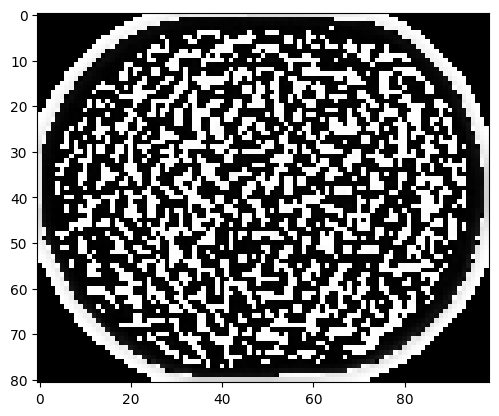

In [9]:
source_ellipse = ellipses[source_img_idx]
current_img = processed_imgs[0]
plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))

Create ellipse to remove border and outter parts of the fruit

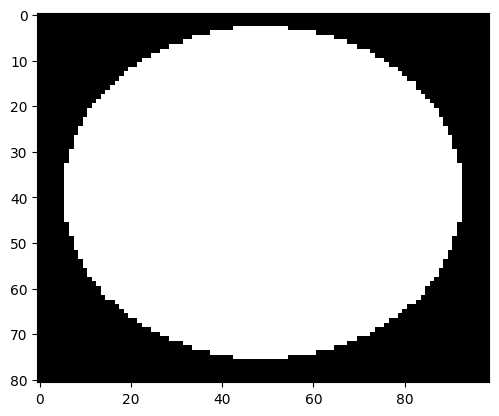

In [10]:
ellipse_mask = np.zeros_like(current_img)
max_exp_rotation_ellipse_axes = [source_ellipse[0][0] / 1.2, source_ellipse[0][1] / 1.2]
max_exp_rotation_ellipse = [max_exp_rotation_ellipse_axes, *source_ellipse[1:]]
draw_filled_ellipse(ellipse_mask, max_exp_rotation_ellipse)
plt.imshow(cv2.cvtColor(ellipse_mask, cv2.COLOR_BGR2RGB))

Create a mask using the ellipse to then select relevant points (L)

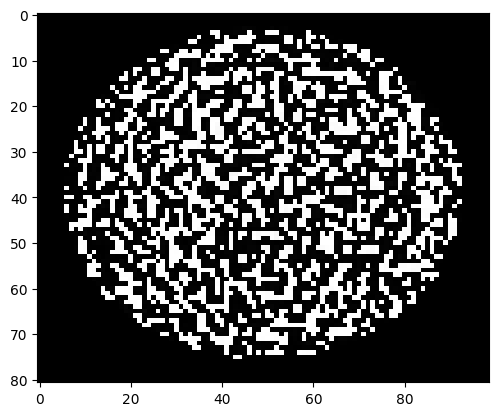

In [11]:
selected_pixels = cv2.bitwise_and(current_img, current_img, mask=ellipse_mask)
plt.imshow(cv2.cvtColor(selected_pixels, cv2.COLOR_BGR2RGB))

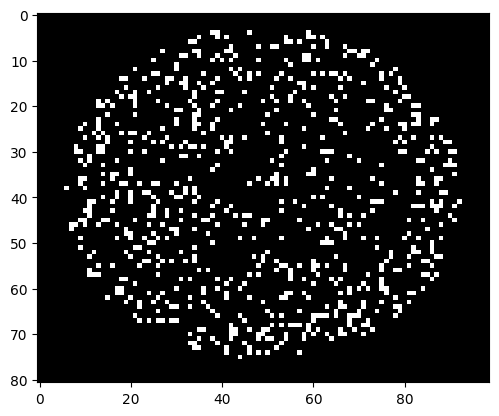

In [12]:
# Compute the 97th percentile of the absolute value
percentile_97 = np.percentile(np.abs(selected_pixels), 97)

# Create a new mask where the pixels that are above the 97th percentile are set to 1
mask_97 = cv2.inRange(selected_pixels, percentile_97, 255)

# Use the new mask to select the pixels from the original image
final_pixels = cv2.bitwise_and(selected_pixels, selected_pixels, mask=mask_97)
plt.imshow(cv2.cvtColor(final_pixels, cv2.COLOR_BGR2RGB))

In [13]:
len(final_pixels)

81